In [32]:
# File Imports
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# Needed for decision tree visualization
import pydotplus 
from IPython.display import Image

# Suppress Warnings
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.simplefilter("ignore", category=FutureWarning)

## Step 1: Load Salary data and perform binning

In [33]:
# Import the data:
file_location = "./resources/data_science_salaries.csv"
file_path = Path(file_location)

salary_df = pd.read_csv(file_path)
# Display the DataFrame:
salary_df.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


<module 'matplotlib.pyplot' from '/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

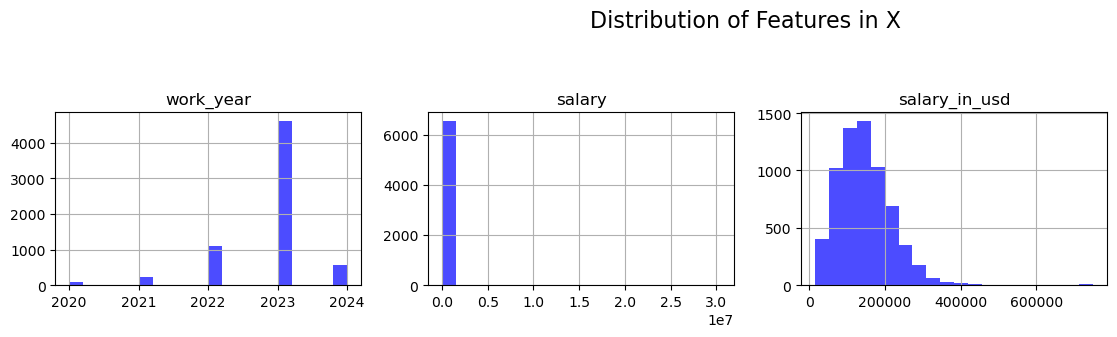

In [34]:
# Graph Feature Dat:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each feature in X
X = salary_df.select_dtypes(include=['float64', 'int64'])  # Select numerical features
X.hist(bins=20, figsize=(15, 10), layout=(4, 4), color='blue', alpha=0.7)
plt.suptitle('Distribution of Features in X', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt

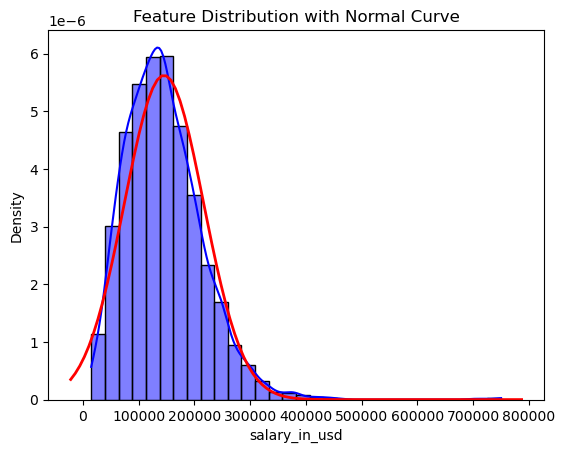

In [35]:
# Choose a specific column from X or y
feature_to_plot = X.iloc[:, 2]  # Replace with specific feature column if needed

# Plot the histogram with KDE
sns.histplot(feature_to_plot, kde=True, stat="density", color="blue", bins=30)
# Overlay a normal distribution
mean, std = feature_to_plot.mean(), feature_to_plot.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2)
plt.title('Feature Distribution with Normal Curve')
plt.show()

In [36]:
# Data Partitioning: Attempt 1 of 2: Calculate the average range based on the 68% of the Empirical rule
mean_salary = np.mean(feature_to_plot)
std_salary = np.std(feature_to_plot)

lower_bound = mean_salary - std_salary
upper_bound = mean_salary + std_salary

print(f"68% range: ({lower_bound}, {upper_bound})")

68% range: (74619.09627855755, 216502.0208604029)


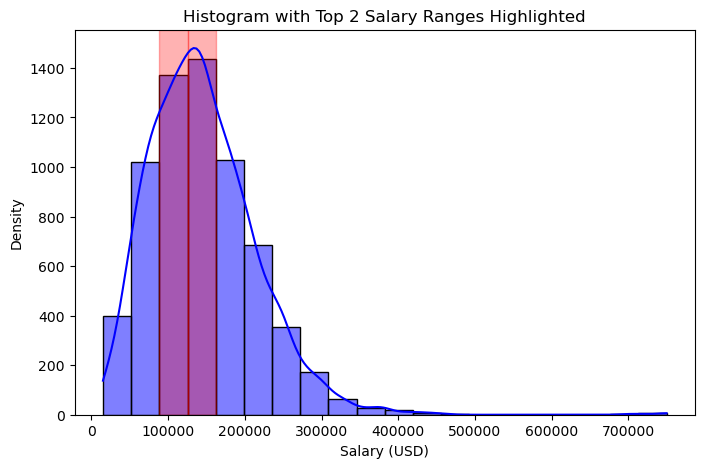

Top 2 most frequent salary ranges: [(88500.0, 125250.0), (125250.0, 162000.0)]


In [37]:
# Data Partitionaing: Attempt 2 of 2: Using the two highest bars as the average
counts, bin_edges = np.histogram(feature_to_plot, bins=20)  # Adjust bins as needed

# Find indices of the two highest bins
top_2_indices = np.argsort(counts)[-2:]  # Get the two highest bins

# Get the corresponding salary ranges
top_2_ranges = [(bin_edges[i], bin_edges[i+1]) for i in top_2_indices]

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(feature_to_plot, bins=20, kde=True, color="blue", alpha=0.5)

# Highlight the two highest bars
for low, high in top_2_ranges:
    plt.axvspan(low, high, color="red", alpha=0.3)  # Highlight range

plt.xlabel("Salary (USD)")
plt.ylabel("Density")
plt.title("Histogram with Top 2 Salary Ranges Highlighted")
plt.show()

# Print the identified ranges
print(f"Top 2 most frequent salary ranges: {top_2_ranges}")

In [38]:
# Binning Employee Salary (y):

# Visual observation of the range of the Highest two bars
bins = [1500, 50000, 156000, 176000, 750000]

# Statical calculation of the range for the Highest two bars
# bins = [1500, 50000, 85000, 162000, 750000]

# Evenly distributed bins:
# bins = [1500, 50000, 100000, 140000, 750000]

# 5 distribution split
# bins = [1500, 50000, 100000, 140000, 200000, 750000] 

# PDCUT: Binning
# salary_df["Employee Salary"], bin_edges = pd.qcut(salary_df["salary_in_usd"], q=4, labels=False, retbins=True)

# Create labels for these bins
group_names = ["very low", "low", "average", "high"]

salary_data = X["salary_in_usd"]
# Slice the data and place it into bins
binned_data = pd.cut(salary_data, bins, labels=group_names, include_lowest=True)
display("Binned Data:", binned_data)
display("Binned Data Info")
binned_data.info()
salary_binned = pd.DataFrame()

# Place the data series into Employee Salary DataFrame
salary_binned["Employee Salary"] = binned_data


'Binned Data:'

0            low
1            low
2            low
3            low
4            low
          ...   
6594    very low
6595    very low
6596         low
6597         low
6598         low
Name: salary_in_usd, Length: 6599, dtype: category
Categories (4, object): ['very low' < 'low' < 'average' < 'high']

'Binned Data Info'

<class 'pandas.core.series.Series'>
RangeIndex: 6599 entries, 0 to 6598
Series name: salary_in_usd
Non-Null Count  Dtype   
--------------  -----   
6599 non-null   category
dtypes: category(1)
memory usage: 6.8 KB


## Step 2: Calculate the employee count and avg salary, per category

In [39]:
# Create DataFrame with binned categories and original salaries
salary_and_bin = pd.DataFrame({"Employee Salary": salary_data, "Salary Bin": binned_data})


# Compute count and mean for each bin
salary_stats = salary_and_bin.groupby("Salary Bin", observed=False)["Employee Salary"].agg(['count', 'mean'])
# Rename columns for clarity
salary_stats.columns = ["Employee Count", "Average Salary"]

# Display as a table
print(salary_stats)

            Employee Count  Average Salary
Salary Bin                                
very low               383    37378.916449
low                   3651   108564.775952
average                652   166347.731595
high                  1913   230741.914794


## Step 3: Data Preprocessing

In [40]:
# Load X dataset:
# Drop collinear data:
X = salary_df.copy()
X = X.drop(columns=["salary", "salary_currency", "salary_in_usd", "work_year"], axis=1)

display("X Info:")
X.info()
display("X Data:", X.head())
display("Work Model value_counts:", X["work_models"].value_counts())

# Get Nominal Column Names Only
nominal_features = X.select_dtypes(include="object").columns

'X Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   employee_residence  6599 non-null   object
 5   company_location    6599 non-null   object
 6   company_size        6599 non-null   object
dtypes: object(7)
memory usage: 361.0+ KB


'X Data:'

,job_title,experience_level,employment_type,work_models,employee_residence,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,United States,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,United States,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,United States,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,United States,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,United States,United States,Medium


'Work Model value_counts:'

work_models
On-site    3813
Remote     2561
Hybrid      225
Name: count, dtype: int64

In [41]:
# Load Y dataset:
y = binned_data
display("X shape:", X.shape)
display("y data:", y[0:5])
display("Y Info:")
y.info()

display("Y shape:", y.shape)
display("Y Describe:", y.describe())
# Check Y distribution
display("Y Value Counts:", y.value_counts())


'X shape:'

(6599, 7)

'y data:'

0    low
1    low
2    low
3    low
4    low
Name: salary_in_usd, dtype: category
Categories (4, object): ['very low' < 'low' < 'average' < 'high']

'Y Info:'

<class 'pandas.core.series.Series'>
RangeIndex: 6599 entries, 0 to 6598
Series name: salary_in_usd
Non-Null Count  Dtype   
--------------  -----   
6599 non-null   category
dtypes: category(1)
memory usage: 6.8 KB


'Y shape:'

(6599,)

'Y Describe:'

count     6599
unique       4
top        low
freq      3651
Name: salary_in_usd, dtype: object

'Y Value Counts:'

salary_in_usd
low         3651
high        1913
average      652
very low     383
Name: count, dtype: int64

## Step 4: Data Encoding

In [42]:
# Preprocessing: Convert Nominal to Ordinal Data with Get Dummies:

X_encoded = pd.get_dummies(X, columns=nominal_features, drop_first=True, dtype=int)
# y_encoded = pd.get_dummies(y, drop_first=True, dtype=int)
le = LabelEncoder()
# One column only (reshape)
y_encoded = le.fit_transform(y)
y_encoded_1_dim = y_encoded
# print("y_encoded:", y_encoded.tolist())
# display("y_encoded:", y_encoded)

y_encoded = y_encoded.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, random_state=1)

display("xTrain:", X_train)
display("yTrain:", y_train)

'xTrain:'

,job_title_AI Developer,job_title_AI Engineer,job_title_AI Product Manager,job_title_AI Programmer,job_title_AI Research Engineer,job_title_AI Scientist,job_title_AWS Data Architect,job_title_Analytics Engineer,job_title_Analytics Engineering Manager,job_title_Applied Data Scientist,...,company_location_Switzerland,company_location_Thailand,company_location_Turkey,company_location_Ukraine,company_location_United Arab Emirates,company_location_United Kingdom,company_location_United States,company_location_Vietnam,company_size_Medium,company_size_Small
477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2857,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


'yTrain:'

array([[1],
       [1],
       [2],
       ...,
       [0],
       [1],
       [1]])

## Step 5: BaseCase: Training 5 Classification Models

In [43]:
# Baseline Pipeline Model Fitting:
# pipe = Pipeline([("Scale", StandardScaler()), ("LR", LinearRegression())])
# KNeighborsClassifier(n_neighbors=5)

models = {
    # Use odd generic number (5) for n_neighbors tie breakers 
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    # Use generic max_depth of 5
    "DTC": DecisionTreeClassifier(max_depth=5),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier(algorithm="SAMME.R")
}

for name, model in models.items():
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])
                                                
    # Fit (Train) the Model
    pipe.fit(X_train, y_train)

    # Make a prediction
    y_pred = pipe.predict(X_test)
    
    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

KNN Score: 0.5230303030303031
              precision    recall  f1-score   support

           0       0.16      0.05      0.07       165
           1       0.38      0.48      0.43       448
           2       0.63      0.66      0.64       945
           3       0.40      0.20      0.26        92

    accuracy                           0.52      1650
   macro avg       0.39      0.35      0.35      1650
weighted avg       0.50      0.52      0.51      1650

SVC Score: 0.5927272727272728
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.50      0.38      0.43       448
           2       0.62      0.84      0.71       945
           3       0.46      0.14      0.22        92

    accuracy                           0.59      1650
   macro avg       0.40      0.34      0.34      1650
weighted avg       0.52      0.59      0.54      1650

DTC Score: 0.6060606060606061
              precision    recall  f1-sc

## Step 6: Model Optimization

In [44]:
# Part 1: Scale and Split data and find Best KNN value:
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 5, Train Score: 0.575 | Test Score: 0.523
k: 7, Train Score: 0.603 | Test Score: 0.559
k: 9, Train Score: 0.600 | Test Score: 0.573
k: 11, Train Score: 0.592 | Test Score: 0.557
k: 13, Train Score: 0.600 | Test Score: 0.587
k: 15, Train Score: 0.600 | Test Score: 0.579
k: 17, Train Score: 0.605 | Test Score: 0.585
k: 19, Train Score: 0.603 | Test Score: 0.587
k: 21, Train Score: 0.603 | Test Score: 0.595
k: 23, Train Score: 0.602 | Test Score: 0.595


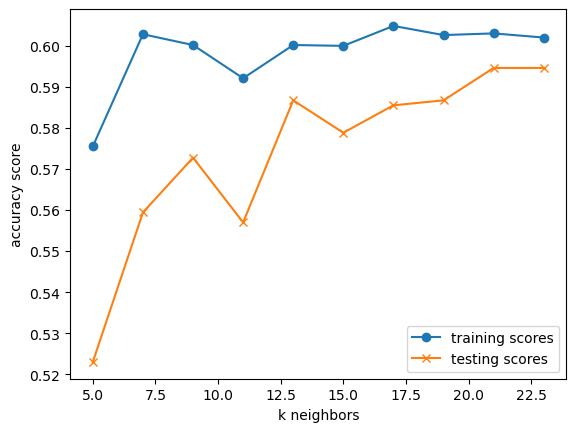

In [45]:
# KNN Optimization 1: Find Best K_nearest neighbor value
train_scores = []
test_scores = []

for k in range(5, 25, 2):
    # Use KNN Classifer Model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Score for training
    train_score = knn.score(X_train_scaled, y_train)
    
    # Score for the test
    test_score = knn.score(X_test_scaled, y_test)
    
    # add the caculated scores to the list we just calculated
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train Score: {train_score:.3f} | Test Score: {test_score:.3f}")
    
# PyPlot Library: Plot the results
# Plot training scores, we need the saved k range for x axis on plot
# Optimal score would be 9, because that is where the testing scores are
# better than our training data.  The first whole number after the testing 
# and training data cross
plt.plot(range(5, 25, 2), train_scores, marker='o', label="training scores")
plt.plot(range(5, 25, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

In [46]:
# KNN Optimation 1: Results with best KNN value:
knn_21 = KNeighborsClassifier(n_neighbors=21)
knn_21.fit(X_train_scaled, y_train)
print('k=21 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))
predictions_knn_21 = knn_21.predict(X_test)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_knn_21, target_names=target_names))

k=21 Test Acc: 0.595
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.35      0.50      0.41       448
           2       0.62      0.67      0.65       945
           3       0.00      0.00      0.00        92

    accuracy                           0.52      1650
   macro avg       0.24      0.29      0.26      1650
weighted avg       0.45      0.52      0.48      1650



/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetric

In [47]:
# KNN Optimization 2: Untuned KNN Model Classification Results
untuned_model = KNeighborsClassifier(n_neighbors=5)
untuned_model.fit(X_train, y_train)
print('Untuned_Model Accuracy Score: %.3f' % untuned_model.score(X_test_scaled, y_test))
# predicted
predictions_untuned = untuned_model.predict(X_test)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_untuned, target_names=target_names))

/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Untuned_Model Accuracy Score: 0.566
              precision    recall  f1-score   support

           0       0.09      0.02      0.03       165
           1       0.46      0.67      0.55       448
           2       0.70      0.67      0.68       945
           3       0.57      0.35      0.43        92

    accuracy                           0.59      1650
   macro avg       0.45      0.43      0.42      1650
weighted avg       0.57      0.59      0.57      1650



In [48]:
# # KNN Option 2a: GridSearchCV Estimator
# # NOT STOPPING: 
# # Find the best params to hypertune the model
# grid_tuned_model = KNeighborsClassifier(n_neighbors=5)
# # every other because it takes a long time, could do all

# # create dictionary with parameters
# grid_parameters = {
#     "n_neighbors": np.arange(11, 21, 2),
#     "leaf_size": np.arange(1, 501),
#     "weights": ["uniform", "distance"]
# }

# # Create the instance of GridSearch CV model, with parameters
# grid_model = GridSearchCV(grid_tuned_model, grid_parameters, verbose=3)

# # Fit the model by using the grid search estimator.
# grid_model.fit(X_train, y_train)
# # List the best parameters for this dataset
# # what is the best leafsize, and params
# print(grid_model.best_params_)

In [49]:
# # KNN Optimization 2b: Rerun model with GridSearchCV Best Fit Estimator
# # Use the best parameters found
# grid_tuned_model = KNeighborsClassifier(
#     n_neighbors=15,  # Best fit value
#     leaf_size=221,    # Best fit value
#     weights="uniform" # Best fit value
#     )

# grid_tuned_model.fit(X_train, y_train)
# print('Random _Tuned_Model Accuracy Score: %.3f' % grid_tuned_model.score(X_test_scaled, y_test))

# # List the best parameters for this dataset
# print("BEST FIT:", grid_tuned_model.best_params_)

# # Make predictions with the hypertuned model
# predictions_tuned = grid_tuned_model.predict(X_test)
# target_names = ["0", "1", "2", "3"]
# print(classification_report(y_test, predictions_tuned, target_names=target_names))

In [50]:
# KNN Optimiataion 2a:  RandomizedSearchCV Estimator
random_tuned_model = KNeighborsClassifier(n_neighbors=5)
random_parameters = {
    "n_neighbors": np.arange(5, 21, 2),
    "leaf_size": np.arange(1, 501),
    "weights": ["uniform", "distance"]
}

random_tuned_model = RandomizedSearchCV(random_tuned_model, random_parameters, verbose=3)

random_tuned_model.fit(X_train, y_train)

target_names = ["0", "1", "2", "3"]

# List the best parameters for this dataset
print("BEST FIT:", random_tuned_model.best_params_)

# Make predictions with the hypertuned model
predications_random = random_tuned_model.predict(X_test)
print(classification_report(y_test, predications_random,target_names=target_names))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END leaf_size=370, n_neighbors=17, weights=uniform;, score=0.563 total time=   0.1s
[CV 2/5] END leaf_size=370, n_neighbors=17, weights=uniform;, score=0.597 total time=   0.1s
[CV 3/5] END leaf_size=370, n_neighbors=17, weights=uniform;, score=0.575 total time=   0.2s
[CV 4/5] END leaf_size=370, n_neighbors=17, weights=uniform;, score=0.602 total time=   0.1s
[CV 5/5] END leaf_size=370, n_neighbors=17, weights=uniform;, score=0.568 total time=   0.1s
[CV 1/5] END leaf_size=464, n_neighbors=9, weights=uniform;, score=0.548 total time=   0.1s
[CV 2/5] END leaf_size=464, n_neighbors=9, weights=uniform;, score=0.592 total time=   0.1s
[CV 3/5] END leaf_size=464, n_neighbors=9, weights=uniform;, score=0.581 total time=   0.1s
[CV 4/5] END leaf_size=464, n_neighbors=9, weights=uniform;, score=0.571 total time=   0.1s
[CV 5/5] END leaf_size=464, n_neighbors=9, weights=uniform;, score=0.578 total time=   0.1s
[CV 1/5] END l

In [51]:
# KNN Optimization 2b: Rerun model with RandomizedSearchCV Best Fit Estimator
# Use the best parameters found
random_tuned_model = KNeighborsClassifier(
    n_neighbors=15,  # Best fit value
    leaf_size=221,    # Best fit value
    weights="uniform" # Best fit value
    )

random_tuned_model.fit(X_train, y_train)
print('Random Model Accuracy Score: %.3f' % random_tuned_model.score(X_test_scaled, y_test))

# predicted
predictions_tuned = random_tuned_model.predict(X_test)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_tuned, target_names=target_names))

/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Random Model Accuracy Score: 0.608
              precision    recall  f1-score   support

           0       0.17      0.01      0.01       165
           1       0.48      0.54      0.51       448
           2       0.66      0.78      0.71       945
           3       0.64      0.17      0.27        92

    accuracy                           0.60      1650
   macro avg       0.49      0.37      0.38      1650
weighted avg       0.56      0.60      0.56      1650



In [52]:
# Optimization 3: RandomOverSampling and RandomUnderSampling
# #Deterimine if  y_encoded is unbalaced:  
# Results indicate uneven distribution, between class 3 (least) and 2 (most)
# Recommendation: OverSampling


print("y_encoded:")
display(pd.Series(y_encoded_1_dim).value_counts())
'''
Class 2 has 3651 samples (dominant class).
Class 1 has 1913 samples.
Class 0 has 652 samples.
Class 3 has 383 samples (least frequent).
'''

y_encoded:


2    3651
1    1913
0     652
3     383
Name: count, dtype: int64

'\nClass 2 has 3651 samples (dominant class).\nClass 1 has 1913 samples.\nClass 0 has 652 samples.\nClass 3 has 383 samples (least frequent).\n'

In [53]:
# Optimization 3a: RandomOverSampling
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_oversampled, y_train_oversampled = over_sampler.fit_resample(X_train, y_train)

# Check new distribution
print("Oversampled Class Distribution")
print(pd.Series(y_train_oversampled).value_counts())

Oversampled Class Distribution
1    2706
2    2706
3    2706
0    2706
Name: count, dtype: int64


In [54]:
# Optimization 3b: Rerun Models with RandomOverSampling dataset
# Results Worse
models = {
    "KNN": KNeighborsClassifier(
    n_neighbors=15,  # Best fit value
    leaf_size=221,    # Best fit value
    weights="uniform" # Best fit value
    ),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

KNN Score: 0.5309090909090909
              precision    recall  f1-score   support

           0       0.15      0.13      0.14       165
           1       0.47      0.44      0.45       448
           2       0.65      0.63      0.64       945
           3       0.36      0.66      0.46        92

    accuracy                           0.53      1650
   macro avg       0.41      0.47      0.42      1650
weighted avg       0.53      0.53      0.53      1650

SVC Score: 0.4036363636363636
              precision    recall  f1-score   support

           0       0.13      0.58      0.22       165
           1       0.52      0.40      0.45       448
           2       0.78      0.35      0.48       945
           3       0.37      0.70      0.48        92

    accuracy                           0.40      1650
   macro avg       0.45      0.50      0.41      1650
weighted avg       0.62      0.40      0.45      1650

DTC Score: 0.4727272727272727
              precision    recall  f1-sc

In [55]:
# Optimization 4a: RandomUnderSampling:
# Apply Random Under Sampling
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=1)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train, y_train)

# Check new distribution
print(pd.Series(y_train_undersampled).value_counts())

0    291
1    291
2    291
3    291
Name: count, dtype: int64


In [56]:
# Optimization 4b: Rerun Models with UnderSampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()  
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_undersampled, y_train_undersampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'Score: {name}; {pipe.score(X_test, y_test)}')
    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


Score: KNN; 0.25272727272727274
KNN Score: 0.25272727272727274
              precision    recall  f1-score   support

           0       0.12      0.83      0.21       165
           1       0.39      0.15      0.22       448
           2       0.81      0.17      0.28       945
           3       0.34      0.57      0.42        92

    accuracy                           0.25      1650
   macro avg       0.42      0.43      0.28      1650
weighted avg       0.60      0.25      0.26      1650

Score: SVC; 0.3993939393939394
SVC Score: 0.3993939393939394
              precision    recall  f1-score   support

           0       0.13      0.39      0.20       165
           1       0.46      0.57      0.51       448
           2       0.79      0.28      0.42       945
           3       0.26      0.78      0.39        92

    accuracy                           0.40      1650
   macro avg       0.41      0.51      0.38      1650
weighted avg       0.60      0.40      0.42      1650

Score:

In [57]:
# Optimization 5a: SMOTEENN ReSampling:
# Apply Random Under Sampling
smt_sampler = SMOTEENN(sampling_strategy='auto', random_state=1)
X_train_resampled, y_train_resampled = smt_sampler.fit_resample(X_train, y_train)

# Check new distribution
print("Classification Distribution")
print(pd.Series(y_train_resampled).value_counts())

Classification Distribution
3    2260
0     596
1     445
2     377
Name: count, dtype: int64


In [58]:
# Optimization 5b: Rerun Models with SMOTEEN Resampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


KNN Score: 0.343030303030303
              precision    recall  f1-score   support

           0       0.12      0.41      0.19       165
           1       0.45      0.44      0.45       448
           2       0.75      0.24      0.36       945
           3       0.21      0.79      0.33        92

    accuracy                           0.34      1650
   macro avg       0.38      0.47      0.33      1650
weighted avg       0.58      0.34      0.37      1650

SVC Score: 0.3624242424242424
              precision    recall  f1-score   support

           0       0.13      0.47      0.20       165
           1       0.53      0.35      0.42       448
           2       0.72      0.30      0.43       945
           3       0.23      0.85      0.36        92

    accuracy                           0.36      1650
   macro avg       0.40      0.49      0.35      1650
weighted avg       0.58      0.36      0.40      1650

DTC Score: 0.3806060606060606
              precision    recall  f1-sco

In [59]:
# Optimization 6a: AdaBoost RandomizedSearchCV Estimator
random_tuned_model = AdaBoostClassifier()
# AdaBoost Parameter Grid
param_grid = {
    "n_estimators": np.arange(50, 201, 10),  # Example: Number of weak learners
    "learning_rate": np.logspace(-3, 0, 20),  # Example: Learning rate (log scale)
    "algorithm": ['SAMME', 'SAMME.R'] #SAMME.R converges faster
}

# RandomizedSearchCV for AdaBoost
random_tuned_model = RandomizedSearchCV(
    AdaBoostClassifier(), param_grid, n_iter=10, cv=5, verbose=3, n_jobs=-1, scoring='accuracy' #Added scoring and cross validation
)

random_tuned_model.fit(X_train, y_train)

target_names = ["0", "1", "2", "3"]

# Best Parameters
print("BEST FIT:", random_tuned_model.best_params_)

# Predictions
predictions_random = random_tuned_model.predict(X_test)
print(classification_report(y_test, predictions_random, target_names=target_names))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vecto

[CV 5/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=120;, score=0.547 total time=   1.1s
[CV 4/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=120;, score=0.546 total time=   1.2s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=120;, score=0.546 total time=   1.5s
[CV 1/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=120;, score=0.547 total time=   1.5s
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.006158482110660267, n_estimators=160;, score=0.547 total time=   1.6s
[CV 2/5] END algorithm=SAMME, learning_rate=0.1623776739188721, n_estimators=120;, score=0.546 total time=   1.6s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vecto

[CV 1/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=90;, score=0.547 total time=   0.7s
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.006158482110660267, n_estimators=160;, score=0.546 total time=   2.0s
[CV 1/5] END algorithm=SAMME.R, learning_rate=0.006158482110660267, n_estimators=160;, score=0.547 total time=   2.1s
[CV 4/5] END algorithm=SAMME.R, learning_rate=0.006158482110660267, n_estimators=160;, score=0.546 total time=   2.1s
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.006158482110660267, n_estimators=160;, score=0.546 total time=   2.1s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vecto

[CV 2/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=90;, score=0.546 total time=   1.1s
[CV 3/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=90;, score=0.546 total time=   0.8s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 5/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=90;, score=0.547 total time=   0.9s
[CV 4/5] END algorithm=SAMME, learning_rate=0.23357214690901212, n_estimators=90;, score=0.546 total time=   1.0s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END algorithm=SAMME.R, learning_rate=0.6951927961775606, n_estimators=140;, score=0.562 total time=   1.4s
[CV 2/5] END algorithm=SAMME, learning_rate=0.6951927961775606, n_estimators=200;, score=0.577 total time=   1.7s
[CV 1/5] END algorithm=SAMME, learning_rate=0.6951927961775606, n_estimators=200;, score=0.579 total time=   1.9s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 3/5] END algorithm=SAMME, learning_rate=0.6951927961775606, n_estimators=200;, score=0.567 total time=   1.9s
[CV 5/5] END algorithm=SAMME, learning_rate=0.6951927961775606, n_estimators=200;, score=0.579 total time=   1.7s
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.6951927961775606, n_estimators=140;, score=0.604 total time=   1.5s
[CV 4/5] END algorithm=SAMME.R, learning_rate=0.6951927961775606, n_estimators=140;, score=0.607 total time=   1.4s
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.6951927961775606, n_estimators=140;, score=0.599 total time=   1.7s
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.6951927961775606, n_estimators=140;, score=0.606 total time=   1.4s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 4/5] END algorithm=SAMME, learning_rate=0.6951927961775606, n_estimators=200;, score=0.604 total time=   2.0s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END algorithm=SAMME, learning_rate=0.006158482110660267, n_estimators=120;, score=0.547 total time=   1.0s
[CV 1/5] END algorithm=SAMME.R, learning_rate=0.05455594781168517, n_estimators=150;, score=0.560 total time=   1.5s
[CV 3/5] END algorithm=SAMME, learning_rate=0.006158482110660267, n_estimators=120;, score=0.546 total time=   1.1s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 5/5] END algorithm=SAMME, learning_rate=0.006158482110660267, n_estimators=120;, score=0.547 total time=   1.0s
[CV 2/5] END algorithm=SAMME, learning_rate=0.006158482110660267, n_estimators=120;, score=0.546 total time=   1.2s
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.05455594781168517, n_estimators=150;, score=0.553 total time=   1.6s
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.05455594781168517, n_estimators=150;, score=0.553 total time=   1.5s
[CV 4/5] END algorithm=SAMME, learning_rate=0.006158482110660267, n_estimators=120;, score=0.546 total time=   1.2s
[CV 4/5] END algorithm=SAMME.R, learning_rate=0.05455594781168517, n_estimators=150;, score=0.568 total time=   1.4s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defaul

[CV 1/5] END algorithm=SAMME.R, learning_rate=0.026366508987303583, n_estimators=50;, score=0.547 total time=   0.4s
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.05455594781168517, n_estimators=150;, score=0.563 total time=   1.5s
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.026366508987303583, n_estimators=50;, score=0.546 total time=   0.5s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vecto

[CV 3/5] END algorithm=SAMME.R, learning_rate=0.026366508987303583, n_estimators=50;, score=0.546 total time=   0.5s
[CV 4/5] END algorithm=SAMME.R, learning_rate=0.026366508987303583, n_estimators=50;, score=0.546 total time=   0.5s
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.026366508987303583, n_estimators=50;, score=0.547 total time=   0.5s


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=100;, score=0.549 total time=   0.9s
[CV 2/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=100;, score=0.562 total time=   1.0s
[CV 3/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=100;, score=0.572 total time=   1.0s
[CV 4/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=100;, score=0.589 total time=   1.0s
[CV 5/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=100;, score=0.582 total time=   1.0s
[CV 1/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=170;, score=0.553 total time=   1.3s
[CV 2/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=170;, score=0.582 total time=   1.3s
[CV 3/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=170;, score=0.570 total time=   1.3s
[CV 4/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=170;, score=0.604 total time=   1.2s
[CV 5/5] END algorithm=SAMME, learning_rate=1.0, n_estimators=170;, score=0.586 total time=   1.2s
BEST FIT: 

In [60]:
# Optimization 6b: Rerun AdaBoost with RandomizedSearchCV Best Fit:

best_params = {'n_estimators': 50, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}

# Create and train the AdaBoost classifier with the best parameters
best_ada = AdaBoostClassifier(**best_params)  # Use ** to unpack the dictionary
best_ada.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_ada.predict(X_test)

print(f'AdaBost Score: {best_ada.score(X_test, y_test)}')


# Evaluate the model
target_names = ["0", "1", "2", "3"]  # Your target names
print(classification_report(y_test, predictions, target_names=target_names))

# #If you want to use the model later, you can save it.
# import joblib
# joblib.dump(best_ada, 'adaboost_model.pkl') #Save the model
# #To load the model later:
# #loaded_ada = joblib.load('adaboost_model.pkl')

AdaBost Score: 0.6139393939393939
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       165
           1       0.51      0.41      0.45       448
           2       0.64      0.83      0.73       945
           3       0.64      0.48      0.55        92

    accuracy                           0.61      1650
   macro avg       0.57      0.43      0.43      1650
weighted avg       0.59      0.61      0.57      1650

